In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from src.cleaning import DataCleaner
import openpyxl

In [2]:
data_cleaner = DataCleaner('data/raw/hpi_po_metro.csv', 'data/raw/ssamatab1.csv')
data_cleaner.clean_unemployment_data
clean_housing_data = data_cleaner.clean_housing_data
clean_unemployment_data = data_cleaner.clean_unemployment_data

In [3]:
clean_unemployment_data.columns

Index(['LAUS_Code', 'State_FIPS_Code', 'FIPS_Code', 'Area', 'Year', 'Month',
       'Civilian_Labor_Force', 'Employment', 'Unemployment',
       'Unemployment_Rate'],
      dtype='object')

In [4]:
# Group the data to create to make it relatable to each other.

grouped_housing_data = clean_housing_data.drop(columns=['Quarter','Not_Seasonally_Adjusted_Index'] ).groupby(['CBSA', 'Metro_Name', 'Year']).agg('mean').reset_index()

grouped_unemployment_data = clean_unemployment_data.drop(columns="Month").groupby(
    ['LAUS_Code', 'State_FIPS_Code','FIPS_Code', 'Area', 'Year']).agg('mean').round(2).reset_index()
grouped_unemployment_data["Unemployment_Rate"] = grouped_unemployment_data["Unemployment_Rate"] / 10

In [5]:
# make SQL database with tables "Unemployment" and "Housing_value"

with sqlite3.connect("database.db") as conn:
    grouped_unemployment_data.to_sql("Unemployment", conn, if_exists='replace', index=False)
    grouped_housing_data.to_sql("Housing_value", conn, if_exists='replace', index=False)

In [6]:
grouped_housing_data.to_excel('data/grouped_housing_data.xlsx', engine="openpyxl", index=False)

In [7]:
grouped_unemployment_data.to_excel('data/grouped_unemployment_data.xlsx', engine="openpyxl", index=False)

In [8]:
combined_tables = """

SELECT 
    Unemployment.LAUS_Code AS Unemployment_LAUS_Code,
    Unemployment.Year AS Unemployment_Year,
    Unemployment.Area AS Unemployment_Area,
    Unemployment.Employment AS Employment,
    Unemployment.Unemployment AS Unemployment,
    Unemployment.Unemployment_Rate AS Unemployment_Rate,
    Housing_value.Metro_Name AS Housing_value_Metro_Name,
    Housing_value.Seasonally_Adjusted_Index AS Housing_value_Seasonally_Adjusted_Index
FROM Unemployment
INNER JOIN Housing_value
    ON Unemployment.FIPS_Code = Housing_value.CBSA
    AND Unemployment.Year = Housing_value.Year
"""

combined_tables_result = pd.read_sql(combined_tables, conn)

In [9]:
correlation = combined_tables_result["Unemployment_Rate"].corr(combined_tables_result["Housing_value_Seasonally_Adjusted_Index"]).round(2)
correlation

np.float64(-0.28)

In [10]:
combined_tables_result.to_excel(excel_writer="data/combined_tables_result.xlsx", index=False, engine="openpyxl")

In [11]:
query1 = """
SELECT * FROM Unemployment
ORDER BY Area
"""
result1 = pd.read_sql(query1, conn)

In [12]:
query2 = """
SELECT * FROM Housing_value
"""
result2 = pd.read_sql(query2, conn)

In [13]:
combined_tables_result.columns

Index(['Unemployment_LAUS_Code', 'Unemployment_Year', 'Unemployment_Area',
       'Employment', 'Unemployment', 'Unemployment_Rate',
       'Housing_value_Metro_Name', 'Housing_value_Seasonally_Adjusted_Index'],
      dtype='object')

<Figure size 1200x800 with 0 Axes>

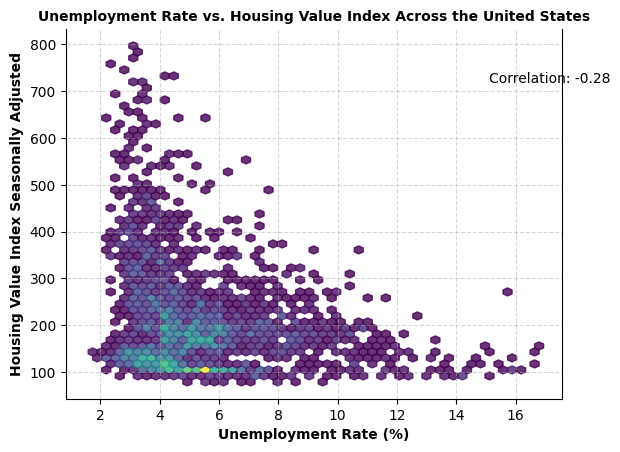

In [14]:
x = combined_tables_result['Unemployment_Rate']
y = combined_tables_result['Housing_value_Seasonally_Adjusted_Index']

plt.figure(figsize=(12,8))
correlation = -0.28

fig, ax = plt.subplots()
ax.spines["top"].set_color("None")

plt.xlabel("Unemployment Rate (%)", fontweight='bold')
plt.ylabel("Housing Value Index Seasonally Adjusted",fontweight='bold')
plt.title("Unemployment Rate vs. Housing Value Index Across the United States", fontsize=10, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.text(x.max() * 0.90, y.max() * 0.90, f'Correlation: {correlation}')

plt.hexbin(x,y, alpha=0.8, gridsize=50,mincnt=1)

plt.show()

In [ ]:
sns.regplot()

TypeError: regplot() takes from 0 to 1 positional arguments but 2 were given